In [1]:
from scipy.stats import beta, norm, binom
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pymc3 as pm

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler


# -- Axes --
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.grid'] = False
rcParams['axes.grid.axis'] = 'y'
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.axisbelow'] = True
rcParams['axes.linewidth'] = 2
rcParams['axes.ymargin'] = 0

# -- Ticks and tick labels --
rcParams['axes.edgecolor'] = 'grey'
rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 5

# -- Fonts --
rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['text.color'] = 'grey'
rcParams['axes.labelcolor'] = 'grey'

# -- Figure size --
rcParams['figure.figsize'] = (10, 7)

# -- Saving Options --
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True

# -- Legend
rcParams['legend.frameon'] = False

# -- Plot Styles --
rcParams['lines.linewidth'] = 1
navy = (56 / 256, 74 / 256, 143 / 256)
teal = (106 / 256, 197 / 256, 179 / 256)
pink = [199 / 256, 99 / 256, 150 / 256]
bbc_grey = [74 / 256, 82 / 256, 93 / 256]
bbc_pink = [225 / 256, 97 / 256, 155 / 256]
bbc_red = [184 / 256, 0, 0]
rcParams['axes.prop_cycle'] = cycler(color=['steelblue'])

# pymc3

In [8]:
def run_simulation(
    holdout_size, test_size, holdout_conversions, test_conversions, match_rate
):
    α_holdout = 1 + holdout_conversions
    β_holdout = 1 + holdout_size - holdout_conversions
    α_match_rate = 1 + int(match_rate * test_size)
    β_match_rate = 1 + test_size - int(match_rate * test_size)
    

    with pm.Model() as model:
        untreated_cr_model = pm.Beta("untreated_cr", alpha = α_holdout, beta = β_holdout)
        match_rate_model = pm.Beta("match_rate", alpha = α_match_rate, beta = β_match_rate)
        treatment_cr_model =  pm.Deterministic("treatment_cr", untreated_cr_model * pm.Uniform("relative_uplift", 1, 1.1))

        untreated_size_model = test_size * (1 - match_rate_model)
        treatment_size_model = test_size * match_rate_model

        untreated_portion_conversions = pm.Deterministic("untreated_conversions", untreated_size_model * untreated_cr_model)

        treatment_portion_conversions = pm.Binomial(
            "treatment_conversions", 
            n=treatment_size_model, 
            p=treatment_cr_model, 
            observed=test_conversions - untreated_portion_conversions
        )

        holdout_conversions = pm.Binomial(
            "holdout_conversions",
            n=holdout_size,
            p=untreated_cr_model,
            observed=holdout_conversions
        )

        trace = pm.sample(20000, step=pm.NUTS())
        
    return trace

In [18]:
def get_trace_number(parameter_name):
    if parameter_name == "untreated_cr":
        return 0, "Untreated CR"
    elif parameter_name == "match_rate":
        return 1, "Match-rate"
    elif parameter_name == "treatment_cr":
        return 2, "Treatment CR"
    elif parameter_name == "relative_uplift":
        return 3, "Relative Uplift"
    
    
def add_hist_plot(ax, trace_data, parameter_name, trace):
    ax.hist(trace_data, density=True, bins=100)
    ax.set_xlim(min(trace_data), max(trace_data))
    if parameter_name == "treatment_cr":
        ax.hist(
            convert_trace_to_pc(trace, "untreated_cr"), 
            density=True, bins=100, 
            alpha=0.5, color='silver'
        )
        
    if parameter_name in ['treatment_cr', 'untreated_cr']:
        ax.set_xlim(
            min(convert_trace_to_pc(trace, "untreated_cr")), 
            max(convert_trace_to_pc(trace, "treatment_cr"))
        )
        
        
def convert_trace_to_pc(trace, parameter_name):
    trace_data = 100 * trace[parameter_name]
    if parameter_name == 'relative_uplift':
        trace_data -= 100
    return trace_data
        

def add_trace_plots(axes, trace, parameter_name, holdout_size=None, holdout_conversions=None):
    trace_data = convert_trace_to_pc(trace, parameter_name)
    plot_row, title_parameter = get_trace_number(parameter_name)
    n_samples = len(trace_data)
    left_pad = 500
    
    
    ax = axes[plot_row, 0]
    ax.spines['left'].set_visible(True)
    parameter_mean = np.round(np.mean(trace_data), 2)
    parameter_std = np.round(np.std(trace_data), 2)
    ax.set_title(f"{title_parameter} Trace (%)")
    ax.plot(trace_data, linewidth=0.5)
    ax.plot([-left_pad, n_samples], [parameter_mean, parameter_mean], color='black', linewidth=1)
    ax.plot(n_samples, parameter_mean, '.', color='black', clip_on=False)
    ax.set_xlim(-left_pad, n_samples + left_pad)
    ax.text(
        x=n_samples,
        y=parameter_mean + 0.25 * parameter_std,
        s=f"Mean: {parameter_mean}%",
        horizontalalignment='right',
        color='black'
    )
    
    ax = axes[plot_row, 1]
    ax.set_title(f"{title_parameter} Distribution")
    add_hist_plot(ax, trace_data, parameter_name, trace)
    
    if holdout_size is not None:
        α_holdout = 1 + holdout_conversions
        β_holdout = 1 + holdout_size - holdout_conversions
        x = np.linspace(min(trace_data), max(trace_data), 1001)
        axes[0, 1].plot(x, 0.01 * beta.pdf(x / 100, α_holdout, β_holdout), color='forestgreen')
#     ax.set_yticks([])
    
#     ax.plot(control_conversions / control_size, 0, '.', markersize=10, color='firebrick', clip_on=False)
#     x = np.linspace(0.01, 0.014, 1001)
#     ax.plot(x, beta.pdf(x, α_control, β_control), color='forestgreen')

# Overall

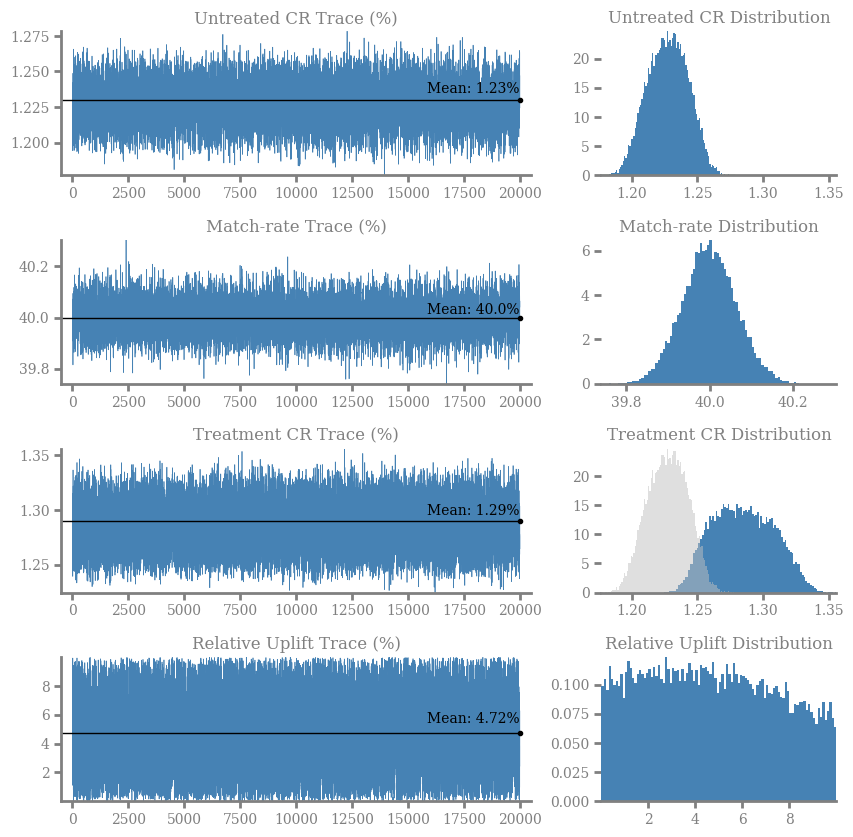

In [19]:
holdout_size = 62_968
test_size = 566_708
holdout_conversions = 31_358
test_conversions = 283_142	
match_rate = 0.4

trace = run_simulation(
    holdout_size, test_size, holdout_conversions, test_conversions, match_rate
)

f, axes = plt.subplots(4, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.45)

add_trace_plots(
    axes, trace[-5000:], "untreated_cr",
    holdout_size=holdout_size, holdout_conversions=holdout_conversions
)
add_trace_plots(axes, trace[-5000:], "match_rate")
add_trace_plots(axes, trace[-5000:], "treatment_cr")
add_trace_plots(axes, trace[-5000:], "relative_uplift")

In [12]:
np.mean(np.random.choice(trace['treatment_cr'], size=len(trace['treatment_cr']), replace=False) > trace['untreated_cr'])

0.998025

In [15]:
np.median(trace["relative_uplift"])

1.0095085285843188

# Glow Up

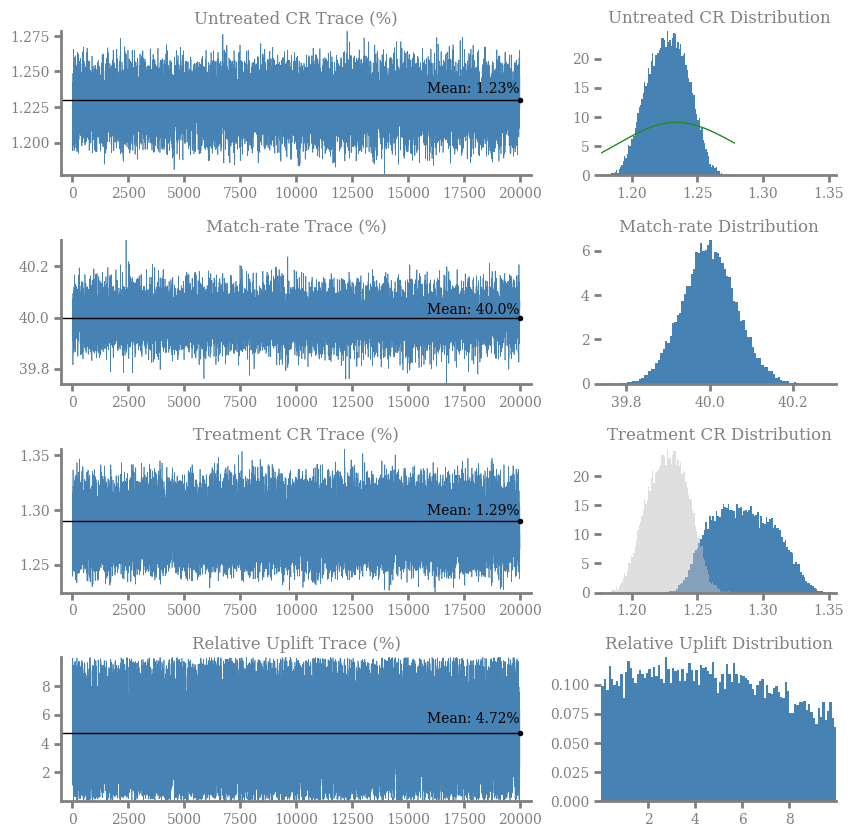

In [20]:
holdout_size = 62_968
test_size = 566_708
holdout_conversions = 777
test_conversions = 7_084
match_rate = 0.4

trace = run_simulation(
    holdout_size, test_size, holdout_conversions, test_conversions, match_rate
)

f, axes = plt.subplots(4, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.45)

add_trace_plots(
    axes, trace[-5000:], "untreated_cr",
    holdout_size=holdout_size, holdout_conversions=holdout_conversions
)
add_trace_plots(axes, trace[-5000:], "match_rate")
add_trace_plots(axes, trace[-5000:], "treatment_cr")
add_trace_plots(axes, trace[-5000:], "relative_uplift")

In [17]:
np.mean(np.random.choice(trace['treatment_cr'], size=len(trace['treatment_cr']), replace=False) > trace['untreated_cr'])

0.9869375

# I Kissed A Boy

/Users/crookm12/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [relative_uplift, match_rate, untreated_cr]


/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 17 seconds.


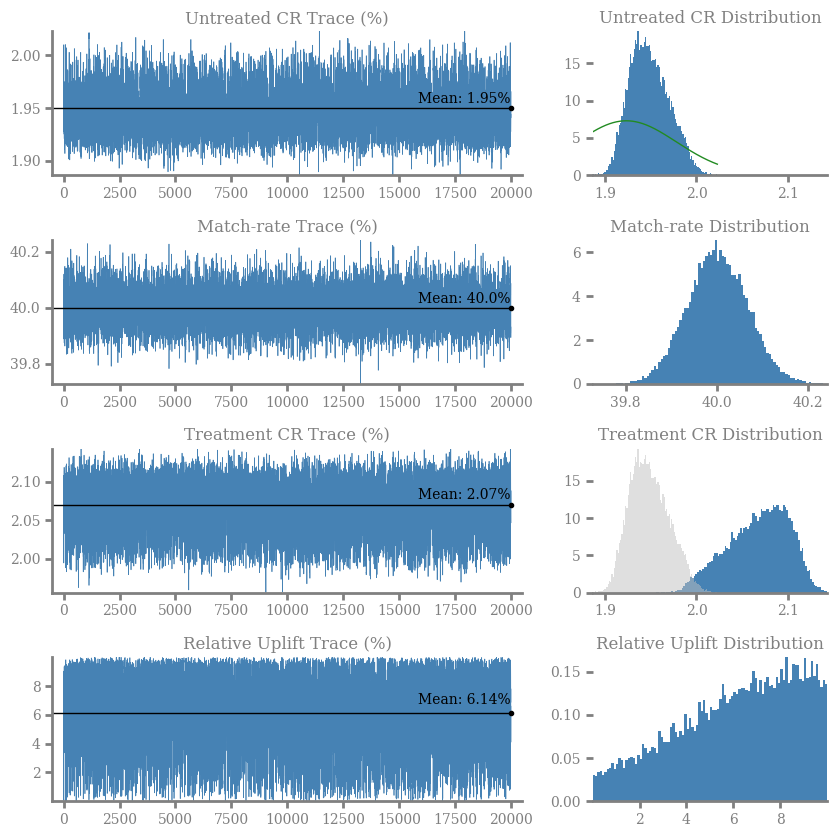

In [21]:
holdout_size = 62_968
test_size = 566_708
holdout_conversions = 1211
test_conversions = 11325
match_rate = 0.4

trace = run_simulation(
    holdout_size, test_size, holdout_conversions, test_conversions, match_rate
)

f, axes = plt.subplots(4, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.45)

add_trace_plots(
    axes, trace[-5000:], "untreated_cr",
    holdout_size=holdout_size, holdout_conversions=holdout_conversions
)
add_trace_plots(axes, trace[-5000:], "match_rate")
add_trace_plots(axes, trace[-5000:], "treatment_cr")
add_trace_plots(axes, trace[-5000:], "relative_uplift")

In [22]:
np.mean(np.random.choice(trace['treatment_cr'], size=len(trace['treatment_cr']), replace=False) > trace['untreated_cr'])

0.9989125

# Waterloo Road

/Users/crookm12/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [relative_uplift, match_rate, untreated_cr]


/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/crookm12/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


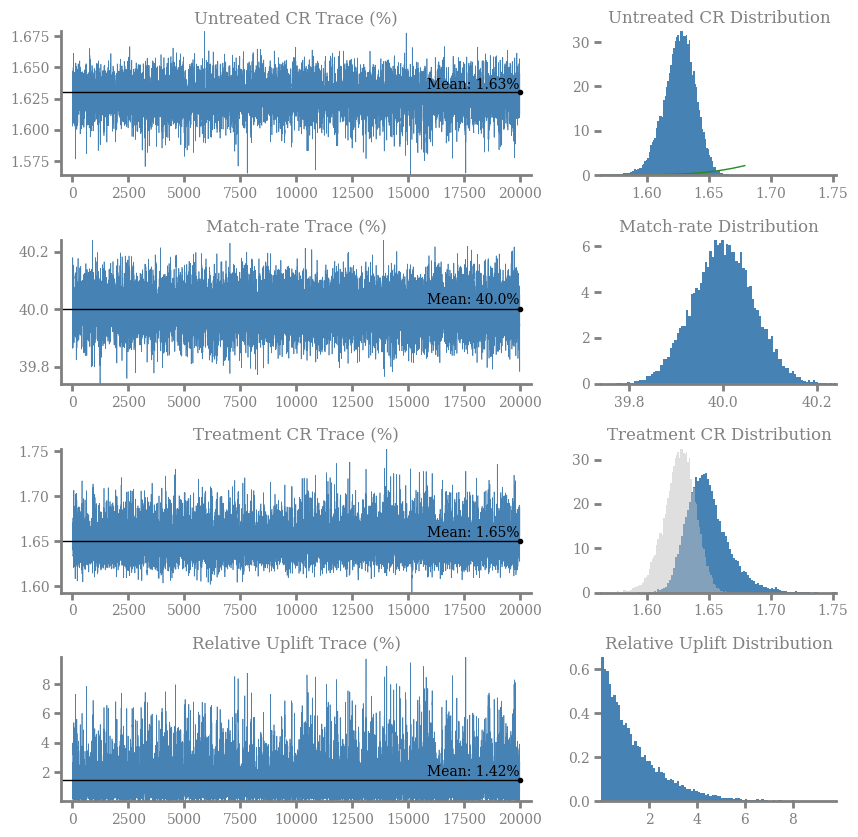

In [23]:
holdout_size = 62_968
test_size = 566_708
holdout_conversions = 1109
test_conversions = 9202
match_rate = 0.4

trace = run_simulation(
    holdout_size, test_size, holdout_conversions, test_conversions, match_rate
)

f, axes = plt.subplots(4, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.45)

add_trace_plots(
    axes, trace[-5000:], "untreated_cr",
    holdout_size=holdout_size, holdout_conversions=holdout_conversions
)
add_trace_plots(axes, trace[-5000:], "match_rate")
add_trace_plots(axes, trace[-5000:], "treatment_cr")
add_trace_plots(axes, trace[-5000:], "relative_uplift")

In [26]:
np.mean(np.random.choice(trace['treatment_cr'], size=len(trace['treatment_cr']), replace=False) > trace['untreated_cr'])

0.8699125

In [25]:
beta.pdf(x / 100, α_control, β_control)

NameError: name 'α_control' is not defined